In [61]:
# data manipulation
import pandas as pd
import numpy as np

# data preprocessing
from scipy.stats import boxcox, yeojohnson, boxcox_normmax, yeojohnson_normmax
from sklearn.preprocessing import LabelEncoder

# data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# custom functions
import constant as c
import visualize as vs
import classifier as cl
import preprocessing as pp
import sampling as smp
import metric as mtr

# model validation
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score
from scipy.stats import skew, kurtosis, median_abs_deviation

In [74]:
test_split = 0.2
label_column = 'act'

In [ ]:
df = pd.read_csv('data/DGA_cleaned.csv', index_col=0)
df[label_column] = df[label_column].astype('category')
df = pp.change_column_name(df)

# Feature Selection
# df = df[['c2h2', 'c2h4', 'act']]

c:\Users\amirl\OneDrive\Desktop\Sampling\preprocessing.py:54: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['act'].replace({'1': 'PD', '2': 'D1', '3': 'D2', '4': 'T1', '5': 'T2', '6': 'T3'}, inplace=True)


In [64]:
# apply data transformation
df_transform = pp.transform_yeojohnson(df.copy())

In [65]:
# split x and y
x=df_transform.drop([label_column],axis=1)
y=df_transform[label_column]

In [66]:
# one hot encoding for deep learning
encoder = LabelEncoder()
y = encoder.fit_transform(y)

In [67]:
# apply data resampling
x, y, df_resample = smp.enn(x, y)

In [68]:
# split train and test data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_split, random_state=42, stratify=y)

In [69]:
# train the model classification
model = cl.svm(X_train, y_train)

In [70]:
# do prediction from model then calculate accuracy using testing
predict = model.predict(X_test)
accuracy_score = mtr.accuracy_score(y_test, predict)

In [71]:
print('Yeo-Johnson ENN SVM')
print('Accuracy:', accuracy_score)

Yeo-Johnson ENN SVM
Accuracy: 0.9558823529411765


In [ ]:
# for deep learning
# predict_softmax = model.predict(X_train)
# predict = pp.softmax(predict_softmax)
# accuracy_score(y_train, predict)

In [81]:
# split into train and testing. then apply resampling on training. then train classifier on training. output the training and testing accuracy.
list_resample = []
for resample in ['no resample', 'enn', 'nearmiss', 'smote', 'adasyn', 'smote_enn', 'smote_nearmiss', 'adasyn_enn', 'adasyn_nearmiss']:
    df = pd.read_csv('data/DGA_cleaned.csv', index_col=0)
    df['act'] = df['act'].astype('category')
    df = pp.transform_yeojohnson(df.copy())
    x=df.drop(['act'],axis=1)
    y=df['act']

    encoder = LabelEncoder()
    y_encoded = encoder.fit_transform(y)
    
    X_train, X_test, y_train, y_test = train_test_split(x, y_encoded, test_size=0.2, random_state=42, stratify=y)
    match resample:
        case 'no resample':
            pass
        case 'enn':
            X_train, y_train, df_resample = smp.enn(X_train, y_train)
        case 'nearmiss':
            X_train, y_train, df_resample = smp.nearmiss(X_train, y_train)
        case 'smote':
            X_train, y_train, df_resample = smp.smote(X_train, y_train)
        case 'adasyn':
            X_train, y_train, df_resample = smp.adasyn(X_train, y_train)
        case 'smote_enn':
            X_train, y_train, df_resample = smp.smote_enn(X_train, y_train)
        case 'smote_adasyn':
            X_train, y_train, df_resample = smp.smote_adasyn(X_train, y_train)

    for classifier in ['mlp', 'cnn', 'decision_tree', 'xgboost', 'rf', 'adaboost', 'svm', 'nb']:
    # for classifier in ['svm']:
        match classifier:
            case 'mlp':
                model = cl.mlp(X_train, y_train)
            case 'cnn':
                model = cl.cnn(X_train, y_train)
            case 'decision_tree':
                model = cl.decision_tree(X_train, y_train)
            case 'xgboost':
                model = cl.xgboost(X_train, y_train)
            case 'rf':
                model = cl.random_forest(X_train, y_train)
            case 'adaboost':
                model = cl.adaboost(X_train, y_train)
            case 'svm':
                model = cl.svm(X_train, y_train)
            case 'nb':
                model = cl.naive_bayes(X_train, y_train)
        
        if classifier == 'mlp' or classifier == 'cnn':
            predict_softmax_train = model.predict(X_train)
            predict_train = pp.softmax(predict_softmax_train)
            predict_softmax_test = model.predict(X_test)
            predict_test = pp.softmax(predict_softmax_test)
        else:
            predict_train = model.predict(X_train)
            predict_test = model.predict(X_test)

        classes = np.unique(y_test)
        precision_train = precision_score(y_train, predict_train, average=None, labels=classes)
        precision_test = precision_score(y_test, predict_test, average=None, labels=classes)
        recall_train = recall_score(y_train, predict_train, average=None, labels=classes)
        recall_test = recall_score(y_test, predict_test, average=None, labels=classes)
        
        data = {
        'Technique': f'{resample} {classifier}',
        'Accuracy Train': mtr.accuracy_score(y_train, predict_train),
        'Precision 0 Train': precision_train[0],
        'Recall 0 Train': recall_train[0],
        'Precision 1 Train': precision_train[1],
        'Recall 1 Train': recall_train[1],
        'Precision 2 Train': precision_train[2],
        'Recall 2 Train': recall_train[2],
        'Precision 3 Train': precision_train[3],
        'Recall 3 Train': recall_train[3],
        'Precision 4 Train': precision_train[4],
        'Recall 4 Train': recall_train[4],
        'Precision 5 Train': precision_train[5],
        'Recall 5 Train': recall_train[5],
        'Accuracy Test': mtr.accuracy_score(y_test, predict_test),
        'Recall 0 Test': recall_test[0],
        'Precision 1 Test': precision_test[1],
        'Recall 1 Test': recall_test[1],
        'Precision 2 Test': precision_test[2],
        'Recall 2 Test': recall_test[2],
        'Precision 3 Test': precision_test[3],
        'Recall 3 Test': recall_test[3],
        'Precision 4 Test': precision_test[4],
        'Recall 4 Test': recall_test[4],
        'Precision 5 Test': precision_test[5],
        'Recall 5 Test': recall_test[5],}
        list_resample.append(data)
    
df_list_resample = pd.DataFrame(list_resample)
# df_list_resample.to_csv('df_classifier split sampling.csv', index=False)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


KeyboardInterrupt: 

In [ ]:
# apply resampling then split into train and testing. then train classifier on training. output the training and testing accuracy.
list_resample = []
for resample in ['no resample', 'enn', 'nearmiss', 'smote', 'adasyn', 'smote_enn', 'smote_nearmiss', 'adasyn_enn', 'adasyn_nearmiss']:
    df = pd.read_csv('data/DGA_cleaned.csv', index_col=0)
    df['act'] = df['act'].astype('category')
    df = pp.transform_yeojohnson(df.copy())
    x=df.drop(['act'],axis=1)
    y=df['act']

    encoder = LabelEncoder()
    y = encoder.fit_transform(y)

    match resample:
        case 'no resample':
            pass
        case 'enn':
            x, y, df_resample = smp.enn(x, y)
        case 'nearmiss':
            x, y, df_resample = smp.nearmiss(x, y)
        case 'smote':
            x, y, df_resample = smp.smote(x, y)
        case 'adasyn':
            x, y, df_resample = smp.adasyn(x, y)
        case 'smote_enn':
            x, y, df_resample = smp.smote_enn(x, y)
        case 'smote_adasyn':
            x, y, df_resample = smp.smote_adasyn(x, y)

    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_split, random_state=42, stratify=y)
    
    # train_df = pd.DataFrame(X_train, columns=c.x_label)
    # train_df['act'] = y_train

    # test_df = pd.DataFrame(X_test, columns=c.x_label)
    # test_df['act'] = y_test

    # train_df.to_csv(f'data/sampling on train and test/train/{resample}.csv', index=False)
    # test_df.to_csv(f'data/sampling on train and test/test/{resample}.csv', index=False)

    for classifier in ['mlp', 'cnn', 'decision_tree', 'xgboost', 'rf', 'adaboost', 'svm', 'nb']:

        match classifier:
            case 'mlp':
                model = cl.mlp(X_train, y_train)
            case 'cnn':
                model = cl.cnn(X_train, y_train)
            case 'decision_tree':
                model = cl.decision_tree(X_train, y_train)
            case 'xgboost':
                model = cl.xgboost(X_train, y_train)
            case 'rf':
                model = cl.random_forest(X_train, y_train)
            case 'adaboost':
                model = cl.adaboost(X_train, y_train)
            case 'svm':
                model = cl.svm(X_train, y_train)
            case 'nb':
                model = cl.naive_bayes(X_train, y_train)
        
        if classifier == 'mlp' or classifier == 'cnn':
            predict_softmax_train = model.predict(X_train)
            predict_train = pp.softmax(predict_softmax_train)
            predict_softmax_test = model.predict(X_test)
            predict_test = pp.softmax(predict_softmax_test)
        else:
            predict_train = model.predict(X_train)
            predict_test = model.predict(X_test)
        
        # df_actual_predict = pd.DataFrame({'actual': y_test, 'predicted': predict_test})
        # df_actual_predict.to_csv(f'data/sampling on train and test/predict/{resample}_{classifier}.csv', index=False)

        classes = np.unique(y_test)
        precision_train = precision_score(y_train, predict_train, average=None, labels=classes)
        precision_test = precision_score(y_test, predict_test, average=None, labels=classes)
        recall_train = recall_score(y_train, predict_train, average=None, labels=classes)
        recall_test = recall_score(y_test, predict_test, average=None, labels=classes)
        
        if classifier == 'enn' or resample == 'svm':
            predict_train = y_train

        data = {
        'Resampling': f'{resample}',
        'Classifier': f'{classifier}',
        'Accuracy Train': mtr.accuracy_score(y_train, predict_train),
        'Precision 0 Train': precision_train[0],
        'Recall 0 Train': recall_train[0],
        'Precision 1 Train': precision_train[1],
        'Recall 1 Train': recall_train[1],
        'Precision 2 Train': precision_train[2],
        'Recall 2 Train': recall_train[2],
        'Precision 3 Train': precision_train[3],
        'Recall 3 Train': recall_train[3],
        'Precision 4 Train': precision_train[4],
        'Recall 4 Train': recall_train[4],
        'Precision 5 Train': precision_train[5],
        'Recall 5 Train': recall_train[5],
        'Accuracy Test': mtr.accuracy_score(y_test, predict_test),
        'Precision 0 Test': precision_test[0],
        'Recall 0 Test': recall_test[0],
        'Precision 1 Test': precision_test[1],
        'Recall 1 Test': recall_test[1],
        'Precision 2 Test': precision_test[2],
        'Recall 2 Test': recall_test[2],
        'Precision 3 Test': precision_test[3],
        'Recall 3 Test': recall_test[3],
        'Precision 4 Test': precision_test[4],
        'Recall 4 Test': recall_test[4],
        'Precision 5 Test': precision_test[5],
        'Recall 5 Test': recall_test[5],}
        list_resample.append(data)
    
df_list_resample = pd.DataFrame(list_resample)
# df_list_resample.to_csv(f'df_classifier pre-split {split} sampling.csv', index=False)

In [75]:
# apply resampling. after that split into train and testing. then apply classifier
list_resample = []
for resample in ['no resample', 'enn', 'nearmiss', 'smote', 'adasyn', 'smote_enn', 'smote_nearmiss', 'adasyn_enn', 'adasyn_nearmiss']:
    df = pd.read_csv('data/DGA_cleaned.csv', index_col=0)
    df['act'] = df['act'].astype('category')
    df = pp.transform_yeojohnson(df.copy())
    x=df.drop(['act'],axis=1)
    y=df['act']
    match resample:
        case 'no resample':
            df_resample = df.copy()
        case 'enn':
            x, y, df_resample = smp.enn(x, y)
        case 'nearmiss':
            x, y, df_resample = smp.nearmiss(x, y)
        case 'smote':
            x, y, df_resample = smp.smote(x, y)
        case 'adasyn':
            x, y, df_resample = smp.adasyn(x, y)
        case 'smote_enn':
            x, y, df_resample = smp.smote_enn(x, y)
        case 'smote_adasyn':
            x, y, df_resample = smp.smote_adasyn(x, y)

    encoder = LabelEncoder()
    y_encoded = encoder.fit_transform(y)
    
    X_train, X_test, y_train, y_test = train_test_split(x, y_encoded, test_size=test_split, random_state=42, stratify=y)
    for classifier in ['mlp', 'cnn', 'decision_tree', 'xgboost', 'rf', 'svm', 'nb']:
        match classifier:
            case 'mlp':
                model = cl.mlp(X_train, y_train)
            case 'cnn':
                model = cl.cnn(X_train, y_train)
            case 'decision_tree':
                model = cl.decision_tree(X_train, y_train)
            case 'xgboost':
                model = cl.xgboost(X_train, y_train)
            case 'rf':
                model = cl.random_forest(X_train, y_train)
            case 'svm':
                model = cl.svm(X_train, y_train)
            case 'nb':
                model = cl.naive_bayes(X_train, y_train)
        
        if classifier == 'mlp' or classifier == 'cnn':
            predict_softmax = model.predict(X_test)
            predict = pp.softmax(predict_softmax)
        else:
            predict = model.predict(X_test)

        classes = np.unique(y_test)
        precision = precision_score(y_test, predict, average=None, labels=classes)
        recall = recall_score(y_test, predict, average=None, labels=classes)
        
        technique = f'{classifier} {resample}'
        data = {
        'Technique': technique,
        'Accuracy': mtr.accuracy_score(y_test, predict),
        'Precision 0': precision[0],
        'Recall 0': recall[0],
        'Precision 1': precision[1],
        'Recall 1': recall[1],
        'Precision 2': precision[2],
        'Recall 2': recall[2],
        'Precision 3': precision[3],
        'Recall 3': recall[3],
        'Precision 4': precision[4],
        'Recall 4': recall[4],
        'Precision 5': precision[5],
        'Recall 5': recall[5],}
        list_resample.append(data)

pd.DataFrame(list_resample).to_csv('df_classifier.csv', index=False)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


KeyboardInterrupt: 

no transform no resample


c:\Users\amirl\OneDrive\Desktop\Sampling\preprocessing.py:54: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['act'].replace({'1': 'PD', '2': 'D1', '3': 'D2', '4': 'T1', '5': 'T2', '6': 'T3'}, inplace=True)


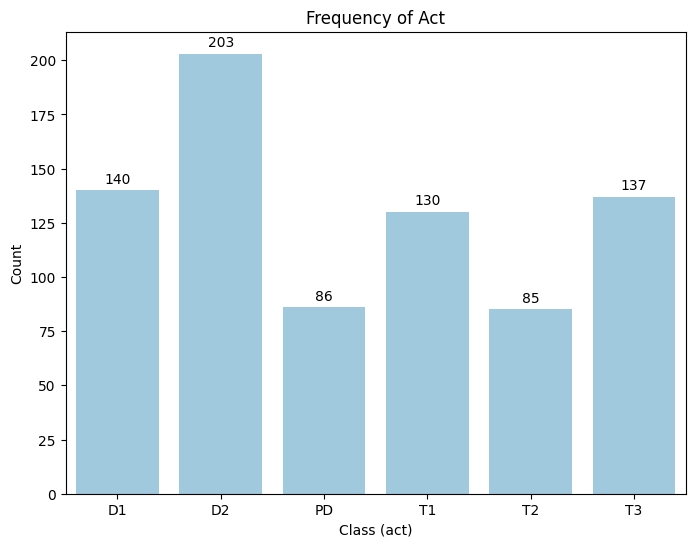

no transform enn


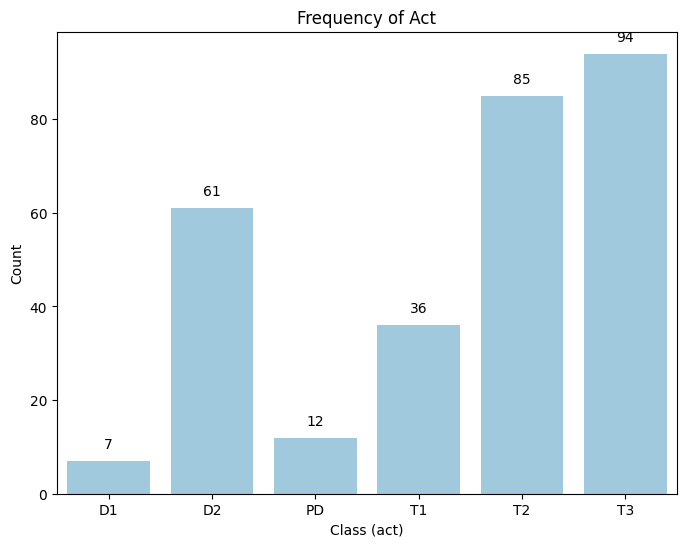

no transform nearmiss


c:\Users\amirl\OneDrive\Desktop\Sampling\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


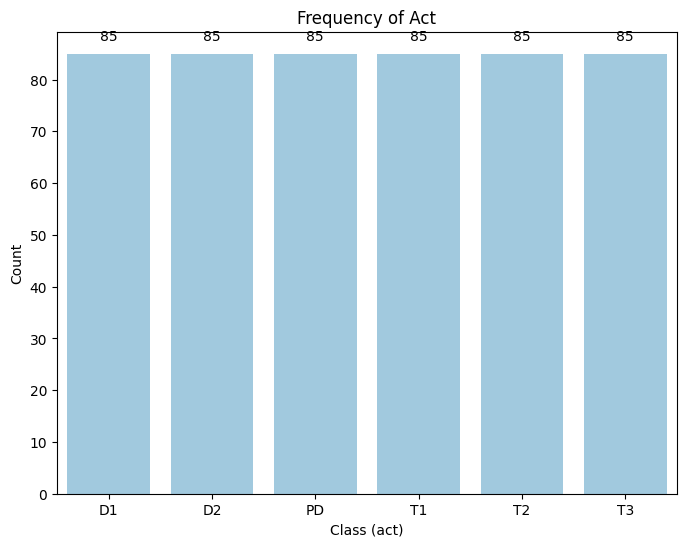

no transform smote


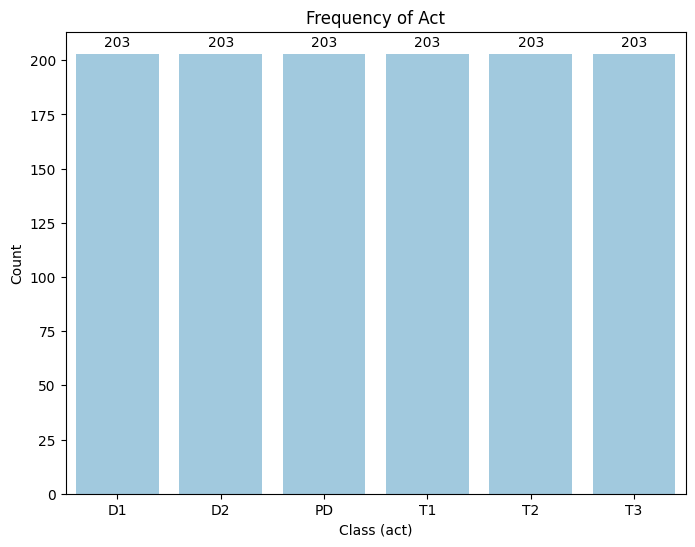

no transform adasyn


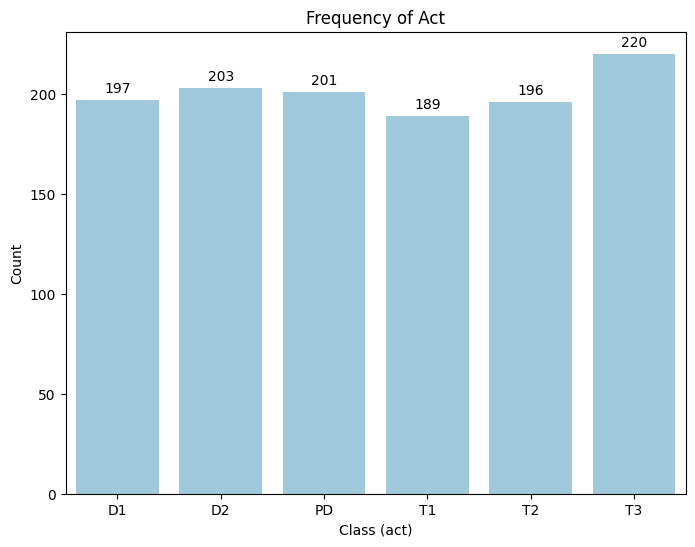

no transform smote_enn


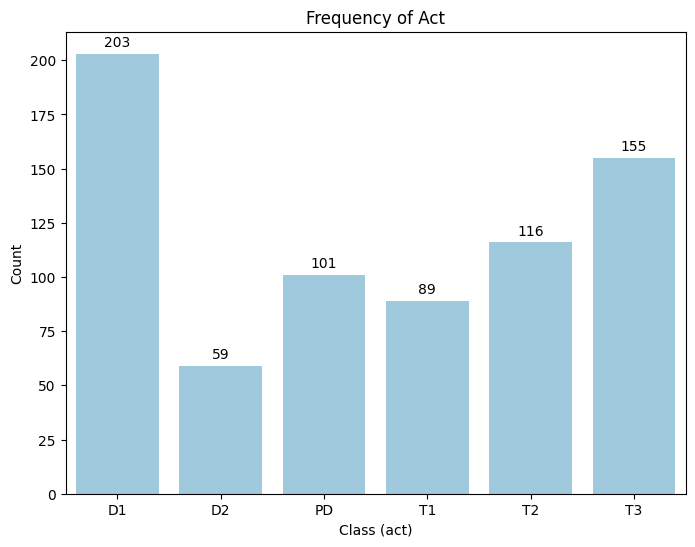

no transform smote_adasyn


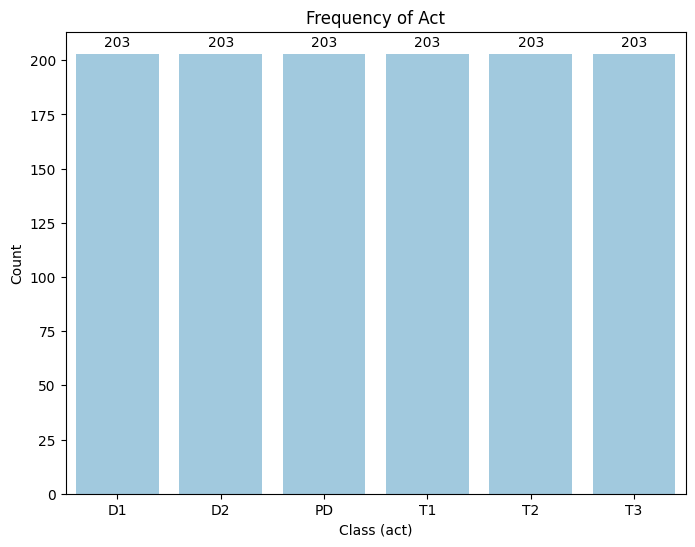

C:\Users\amirl\AppData\Local\Temp\ipykernel_17200\2445646962.py:117: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df_combine.groupby(['act', 'resample']).size().reset_index(name='count')
c:\Users\amirl\OneDrive\Desktop\Sampling\preprocessing.py:54: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['act'].replace({'1': 'PD', '

log no resample


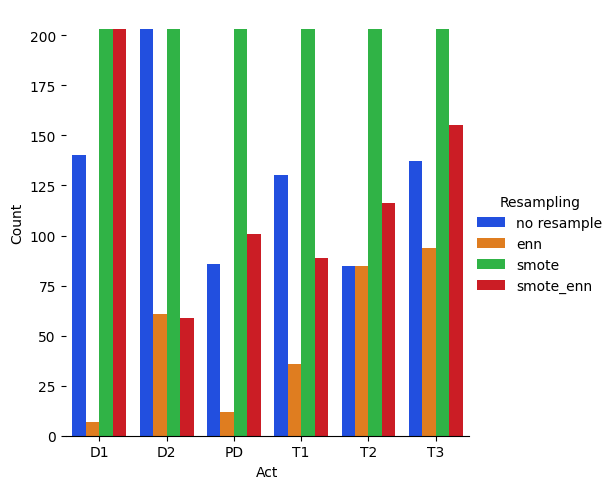

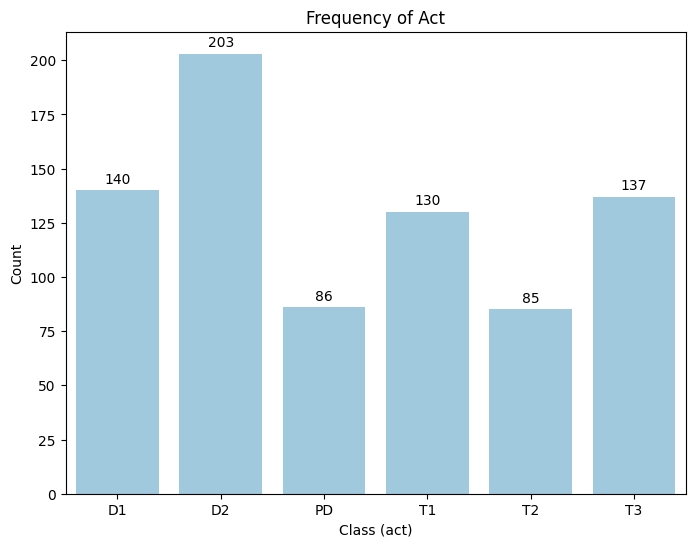

log enn


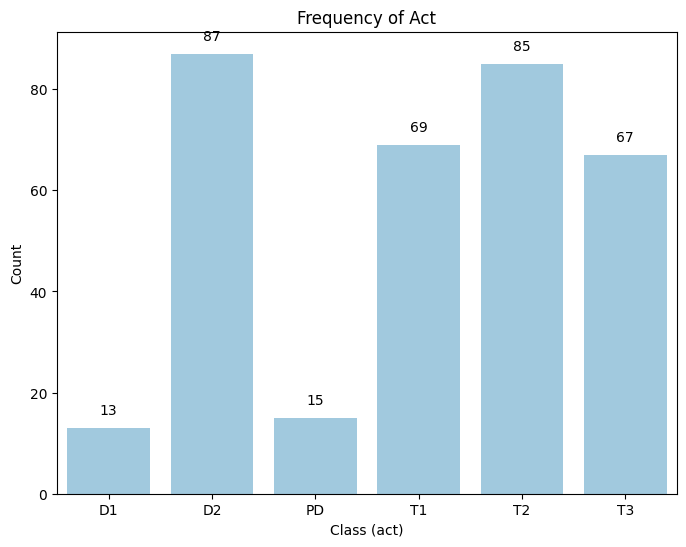

log nearmiss


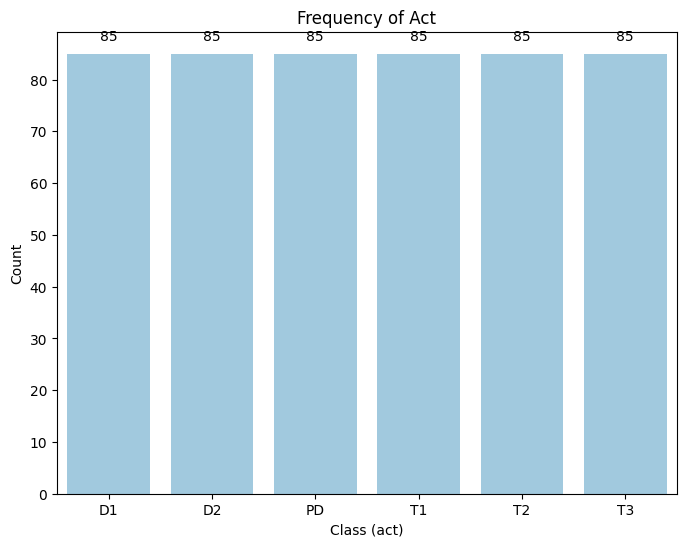

log smote


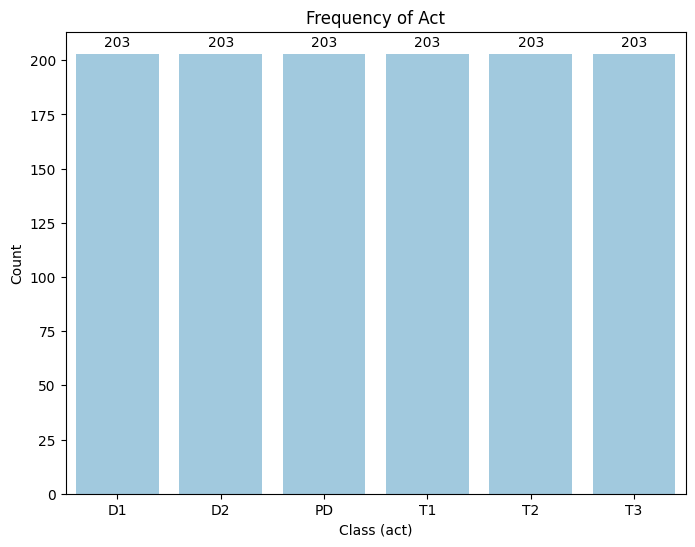

log adasyn


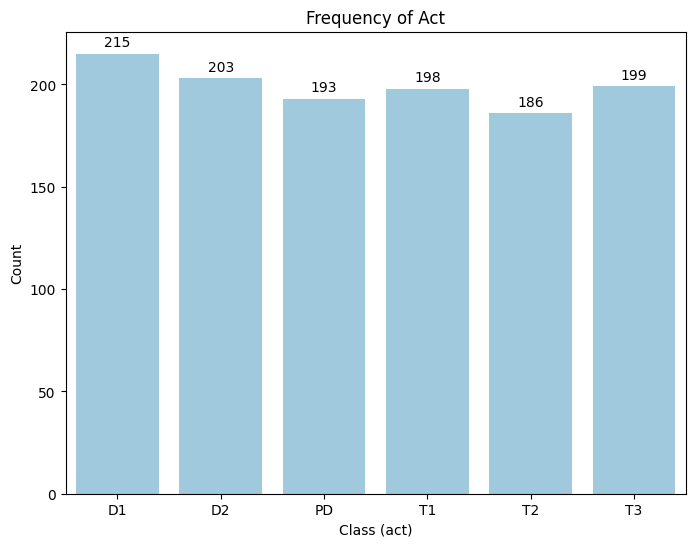

log smote_enn


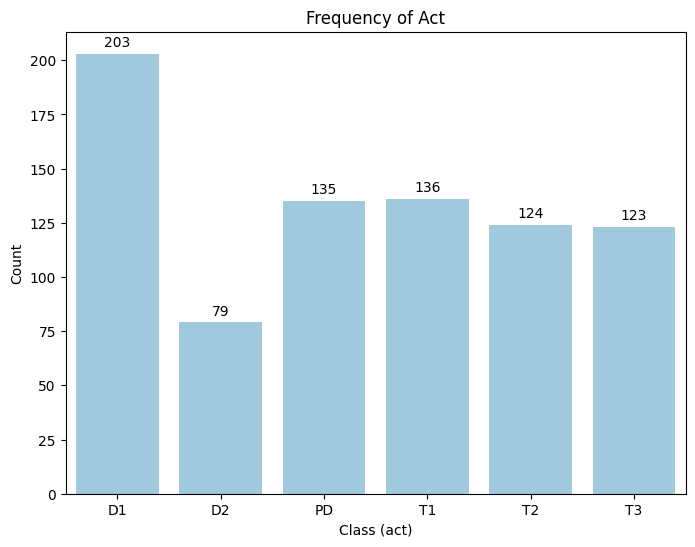

log smote_adasyn


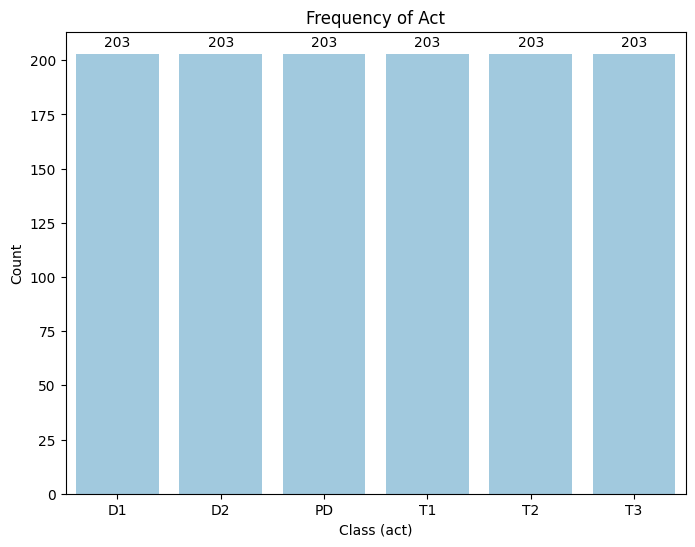

C:\Users\amirl\AppData\Local\Temp\ipykernel_17200\2445646962.py:117: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df_combine.groupby(['act', 'resample']).size().reset_index(name='count')


log1p no resample


c:\Users\amirl\OneDrive\Desktop\Sampling\preprocessing.py:54: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['act'].replace({'1': 'PD', '2': 'D1', '3': 'D2', '4': 'T1', '5': 'T2', '6': 'T3'}, inplace=True)


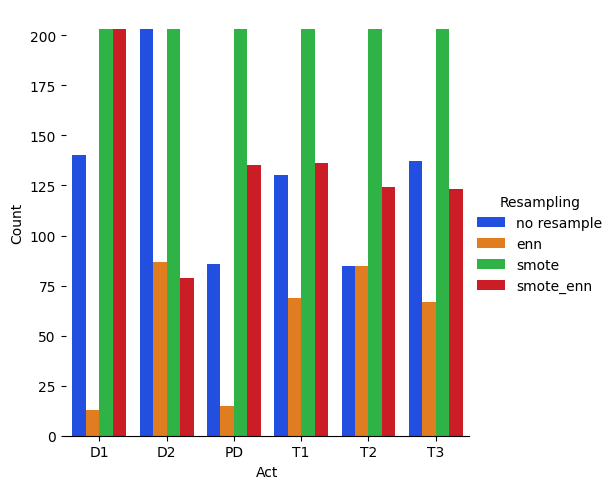

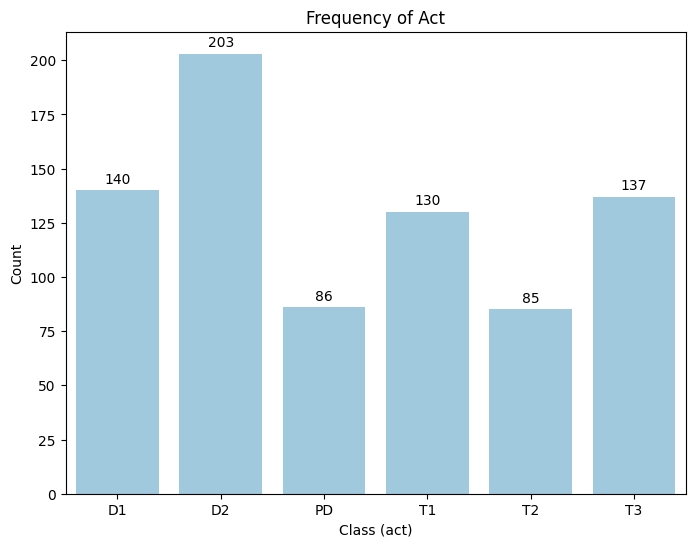

log1p enn


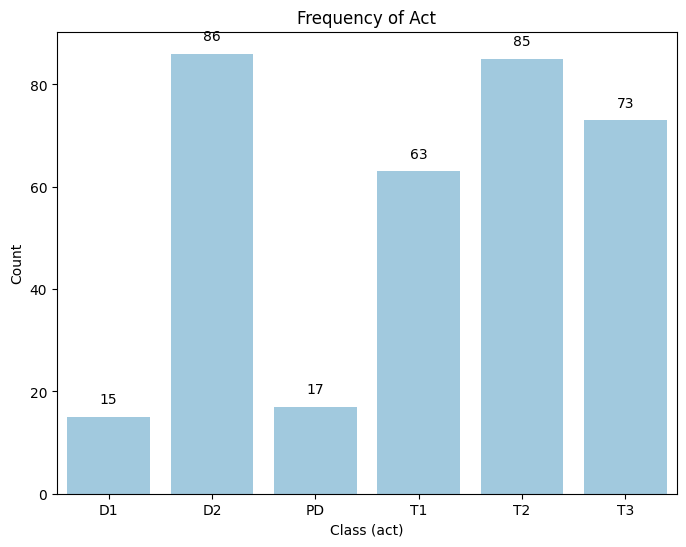

log1p nearmiss


c:\Users\amirl\OneDrive\Desktop\Sampling\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


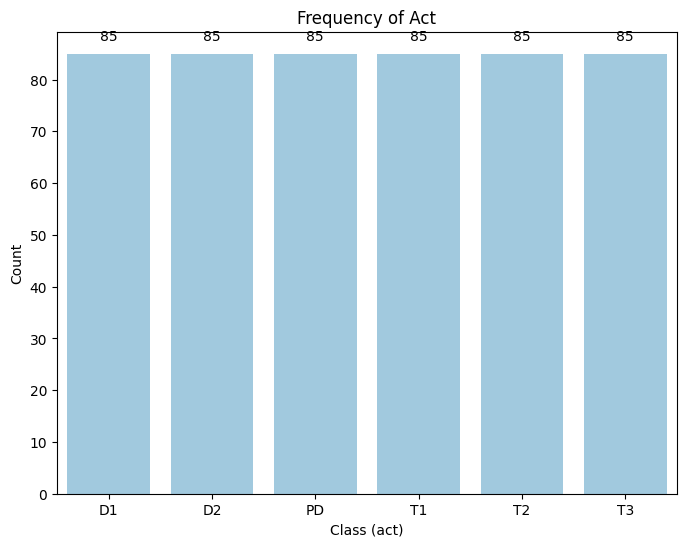

log1p smote


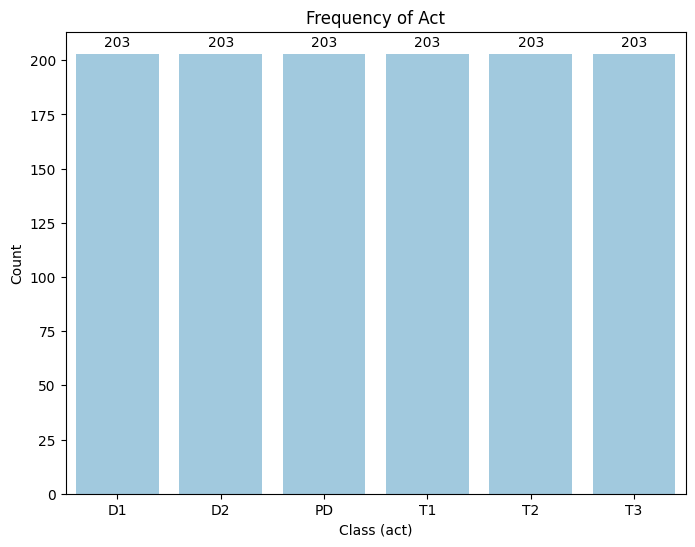

log1p adasyn


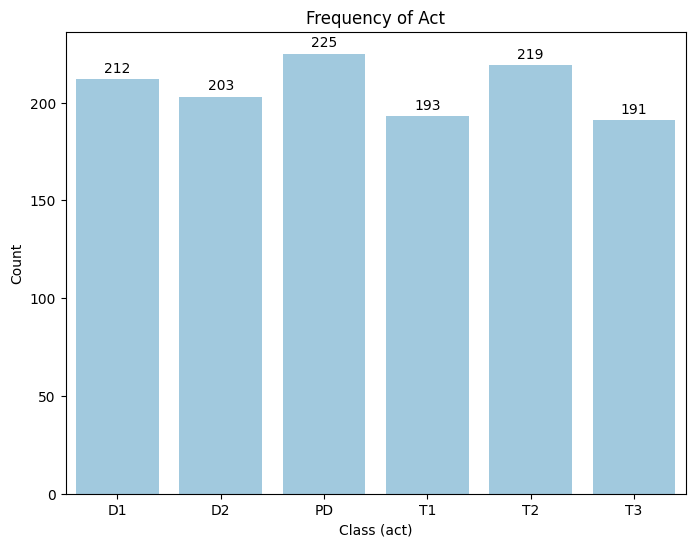

log1p smote_enn


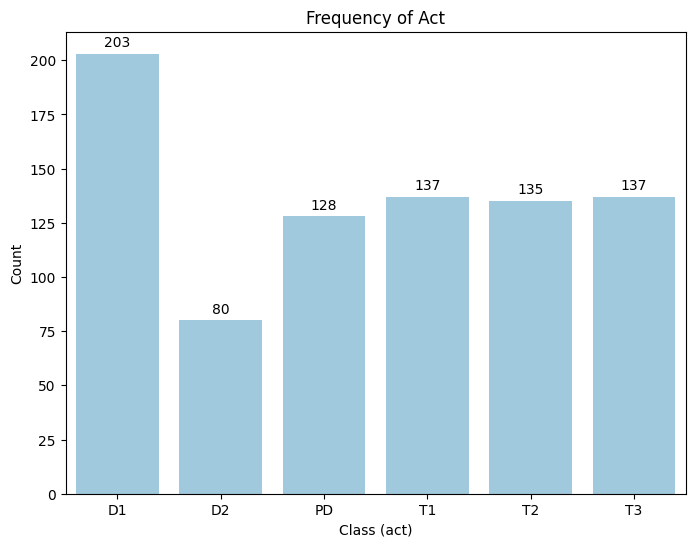

log1p smote_adasyn


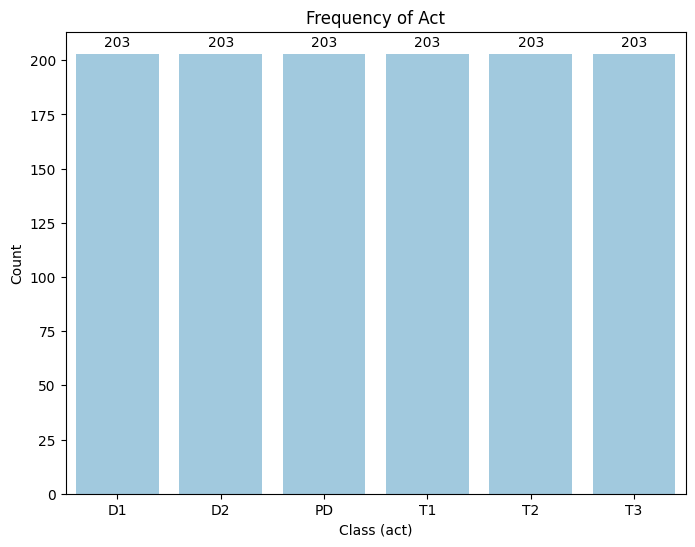

square root no resample


C:\Users\amirl\AppData\Local\Temp\ipykernel_17200\2445646962.py:117: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df_combine.groupby(['act', 'resample']).size().reset_index(name='count')
c:\Users\amirl\OneDrive\Desktop\Sampling\preprocessing.py:54: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['act'].replace({'1': 'PD', '

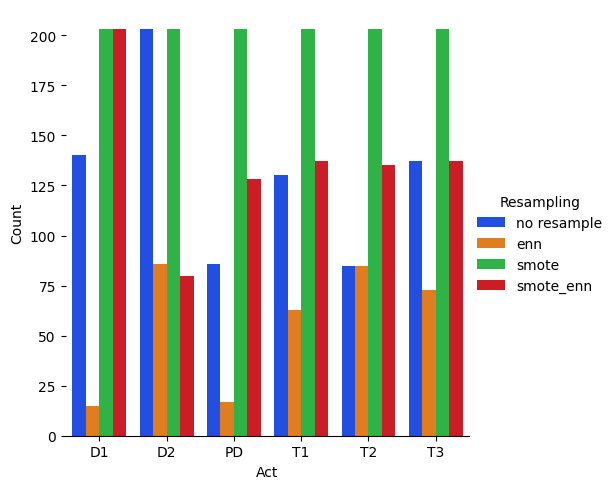

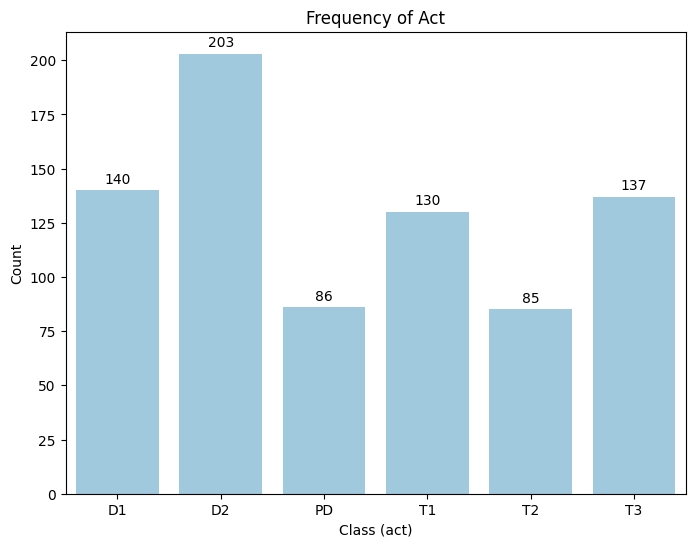

square root enn


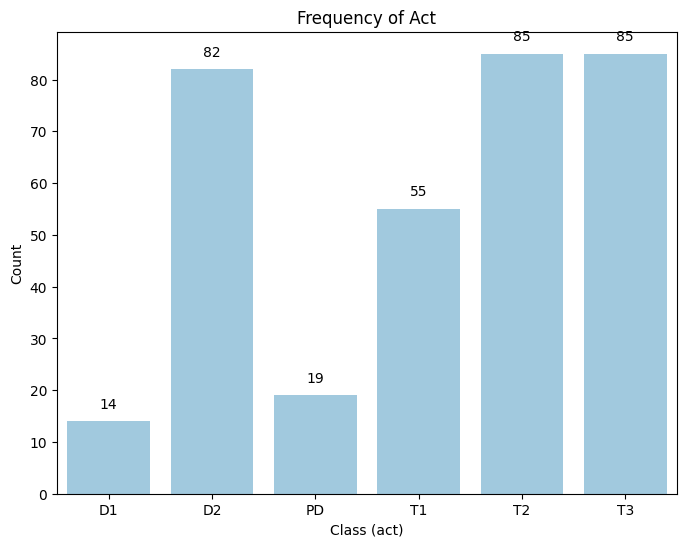

square root nearmiss


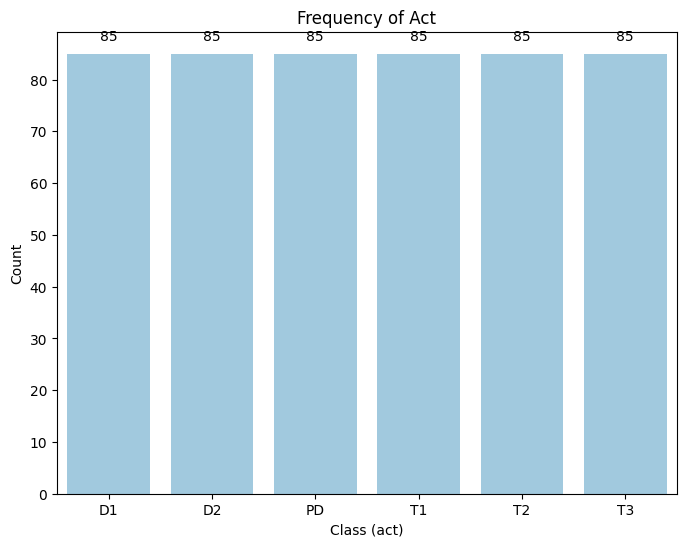

square root smote


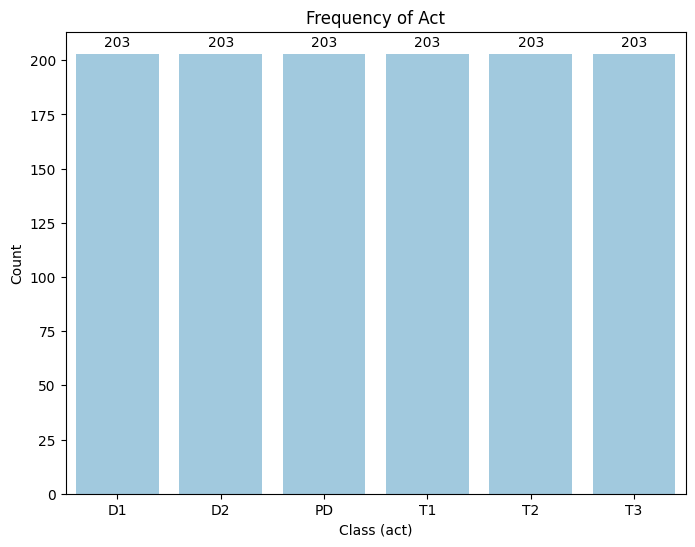

square root adasyn


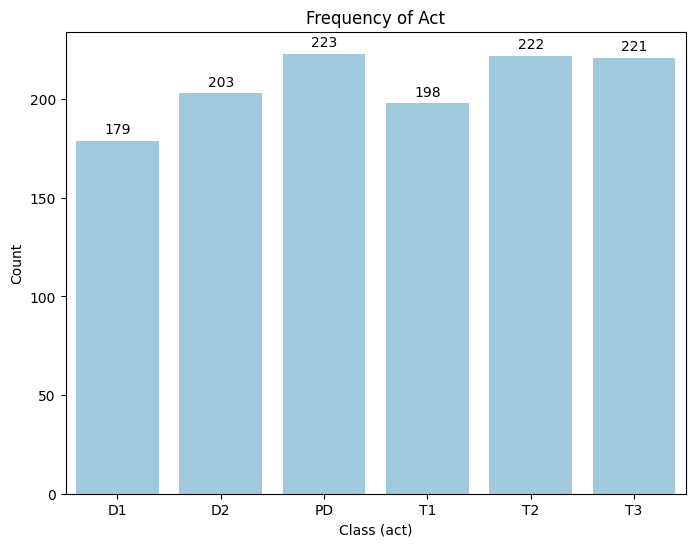

square root smote_enn


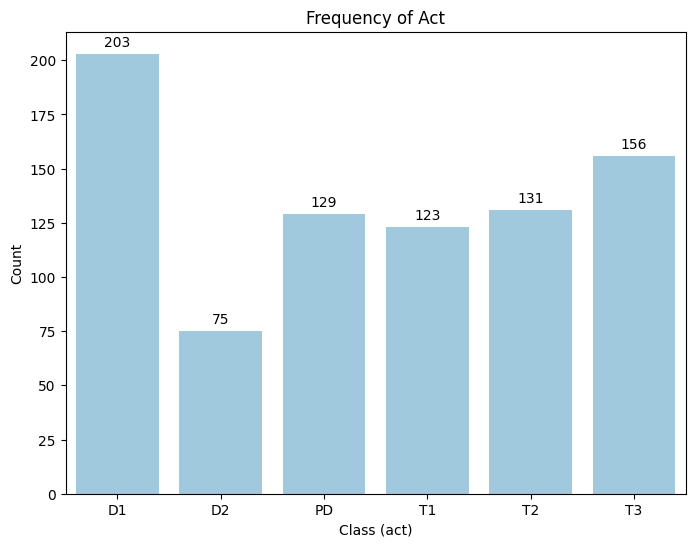

square root smote_adasyn


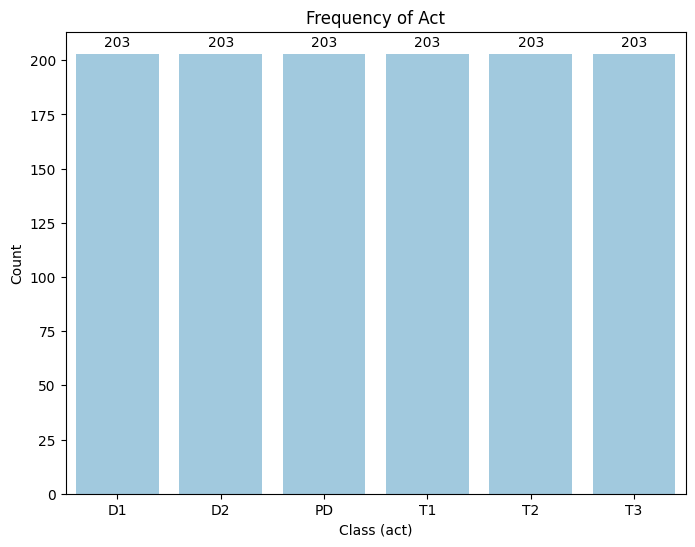

C:\Users\amirl\AppData\Local\Temp\ipykernel_17200\2445646962.py:117: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df_combine.groupby(['act', 'resample']).size().reset_index(name='count')
c:\Users\amirl\OneDrive\Desktop\Sampling\preprocessing.py:54: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['act'].replace({'1': 'PD', '

boxcox no resample


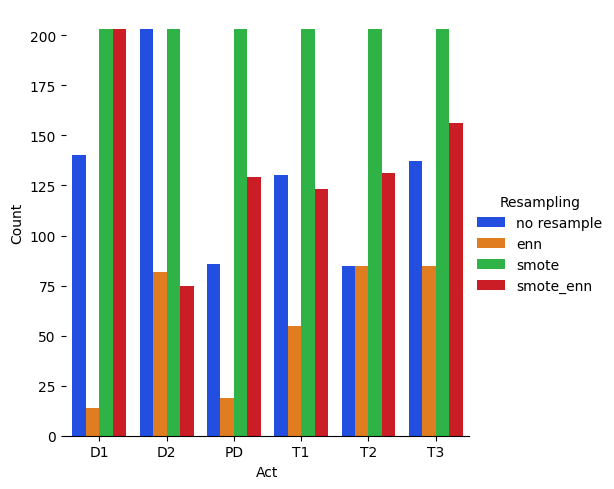

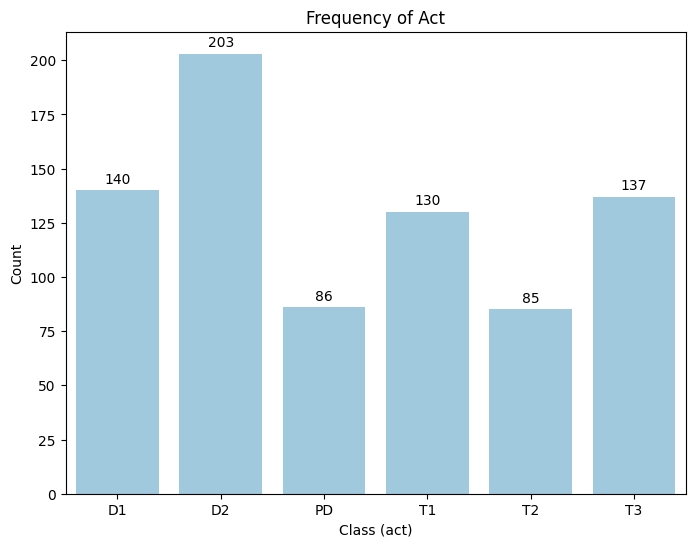

boxcox enn


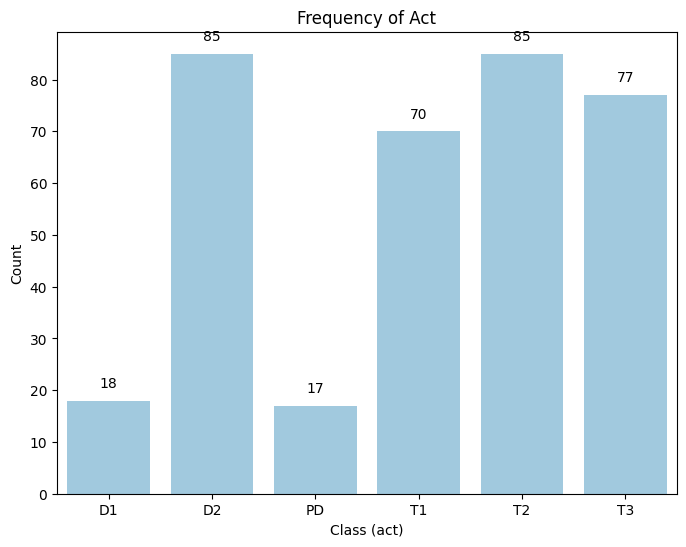

boxcox nearmiss


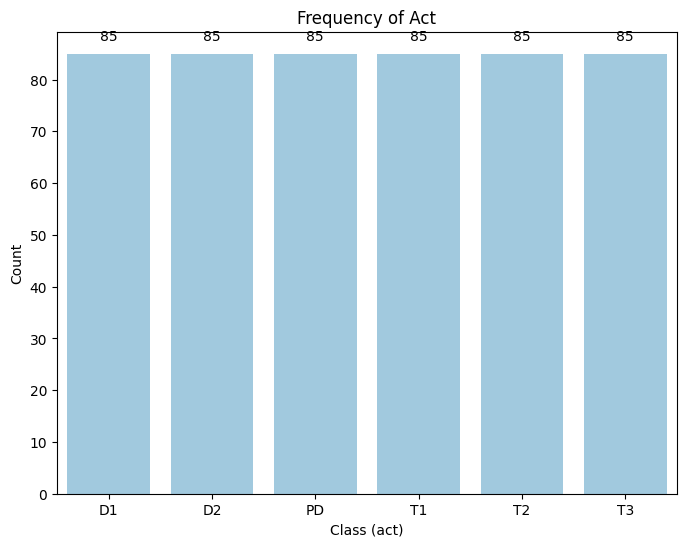

boxcox smote


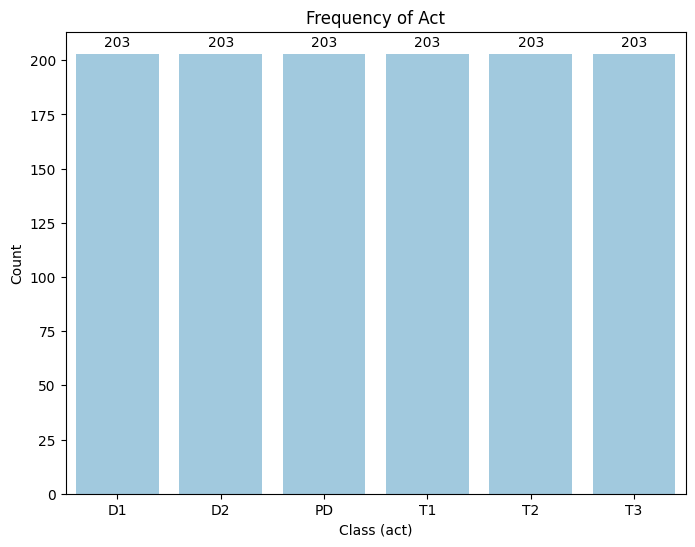

boxcox adasyn


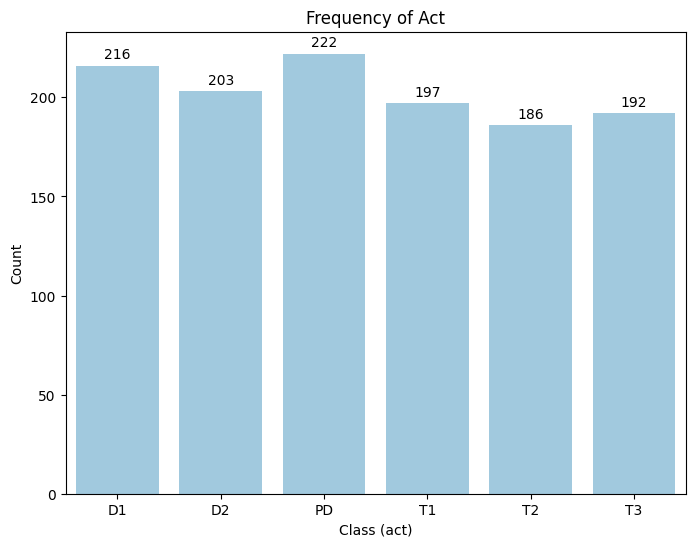

boxcox smote_enn


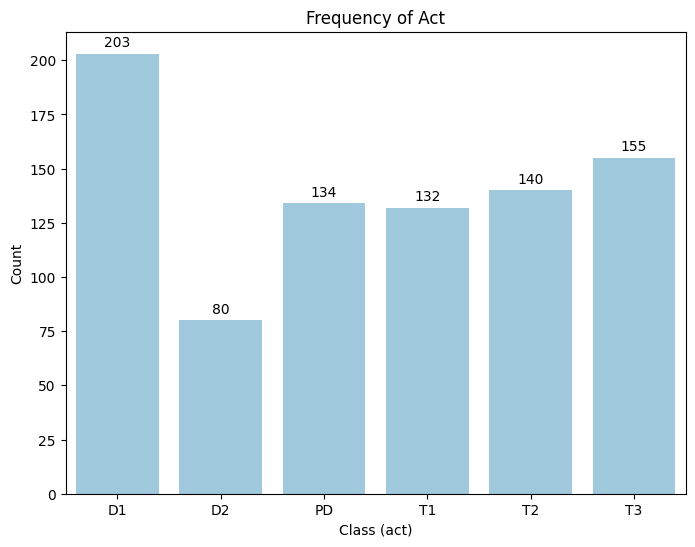

boxcox smote_adasyn


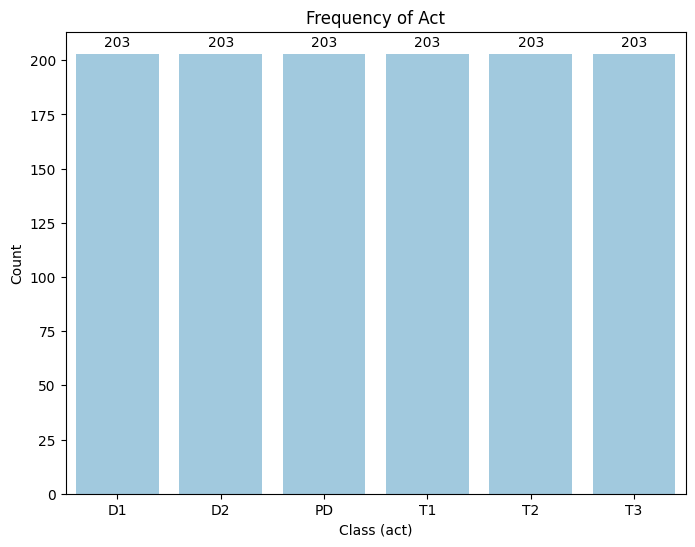

C:\Users\amirl\AppData\Local\Temp\ipykernel_17200\2445646962.py:117: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df_combine.groupby(['act', 'resample']).size().reset_index(name='count')
c:\Users\amirl\OneDrive\Desktop\Sampling\preprocessing.py:54: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['act'].replace({'1': 'PD', '

yeo johnson no resample


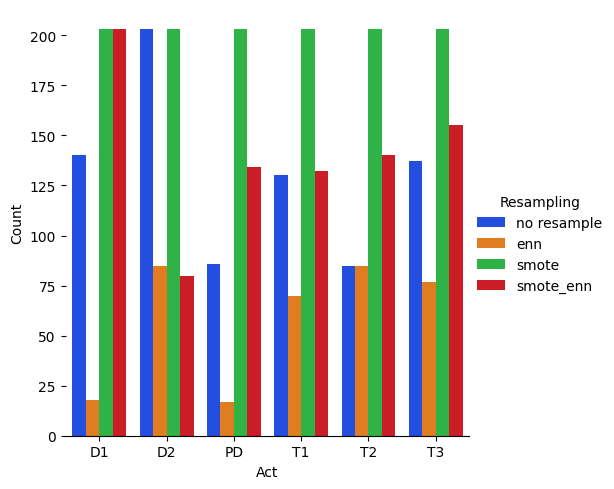

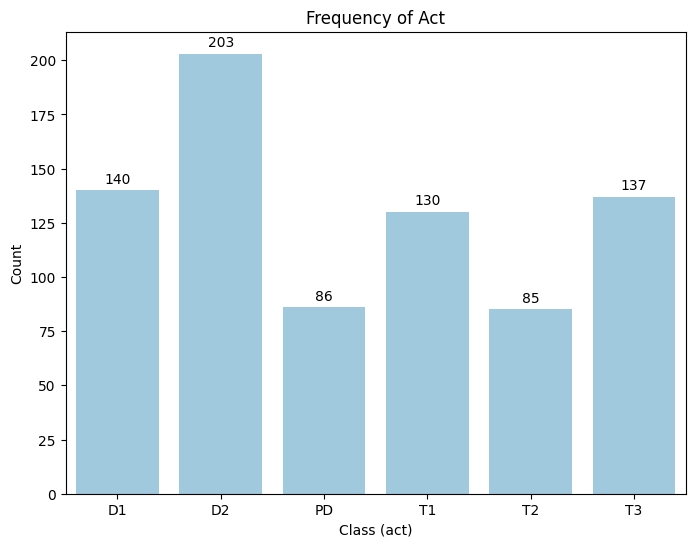

yeo johnson enn


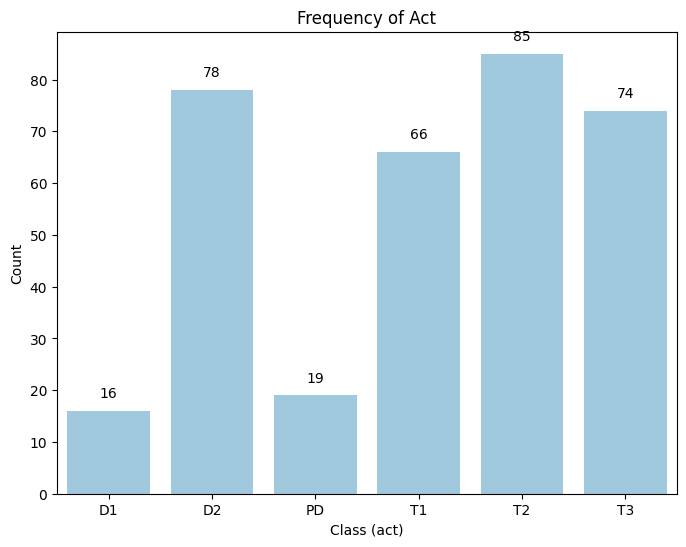

yeo johnson nearmiss


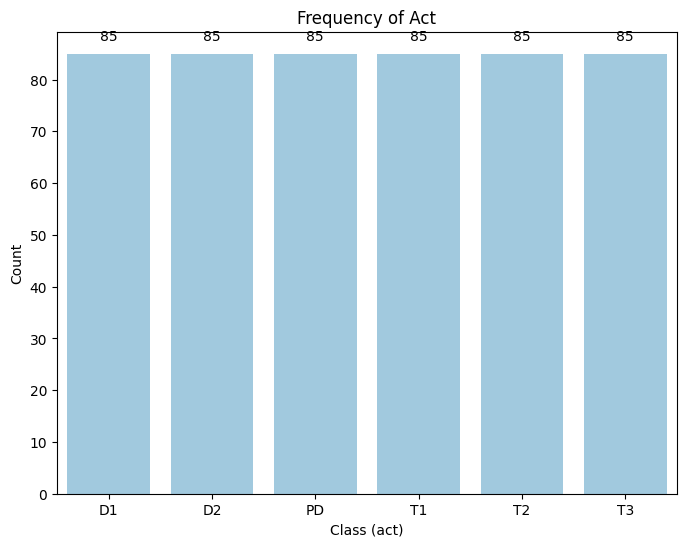

yeo johnson smote


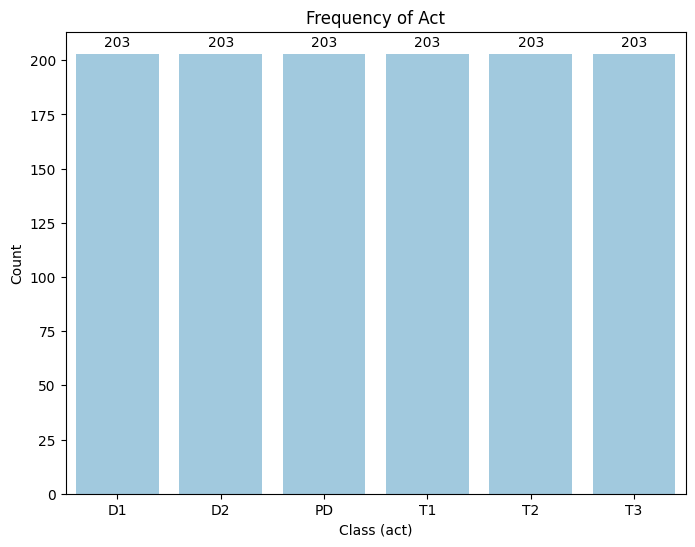

yeo johnson adasyn


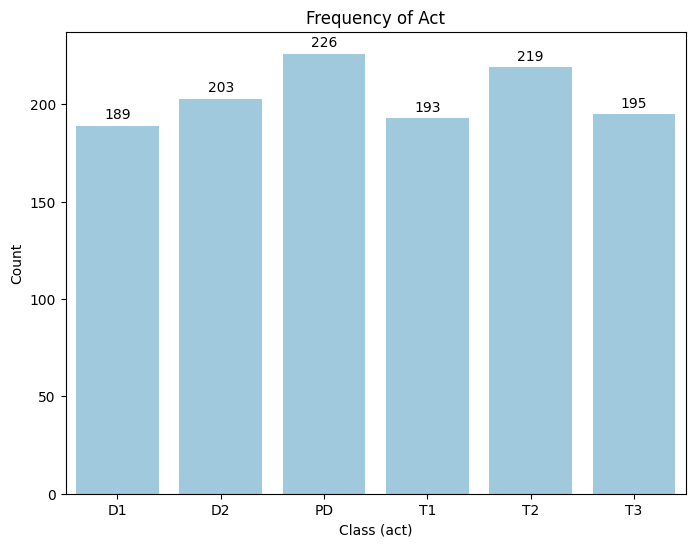

yeo johnson smote_enn


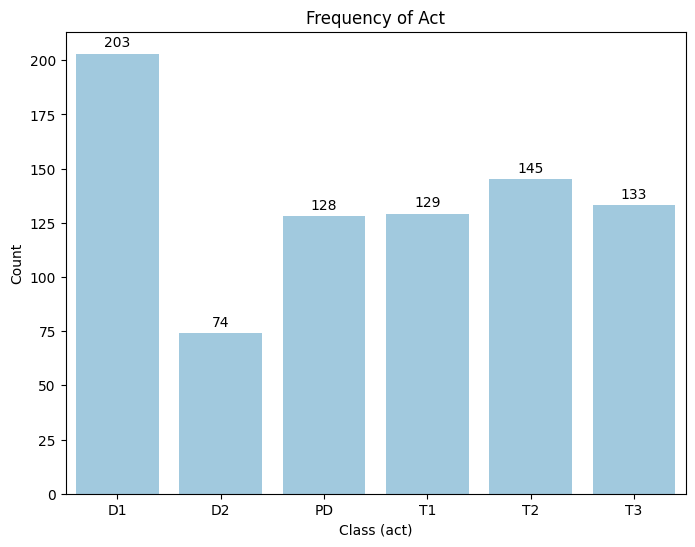

yeo johnson smote_adasyn


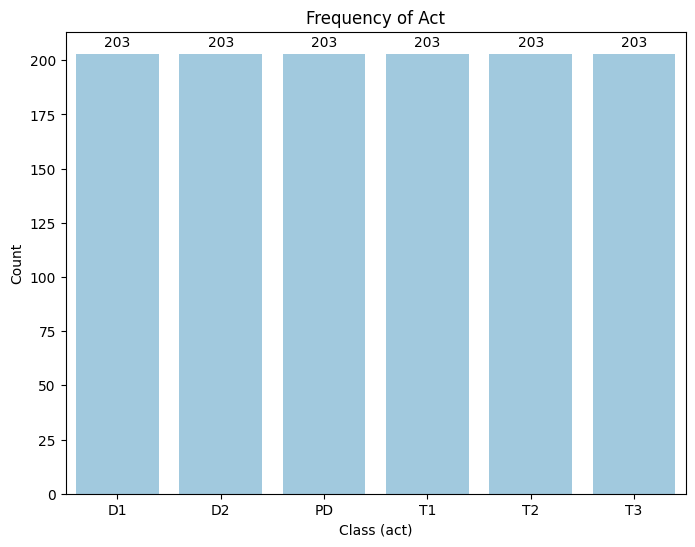

C:\Users\amirl\AppData\Local\Temp\ipykernel_17200\2445646962.py:117: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df_combine.groupby(['act', 'resample']).size().reset_index(name='count')


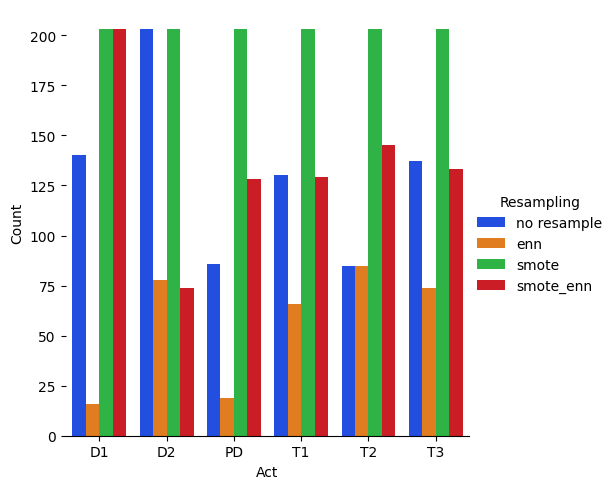

In [ ]:
# apply feature tranformation then resampling. after that split into train and testing. then apply classifier. also calculate EDA

list_resample = []
list_eda = []
num = 1
for transform in ['no transform', 'log', 'log1p', 'square root', 'boxcox', 'yeo johnson']:
    df_combine = pd.DataFrame()
    df = pd.read_csv('data/DGA_cleaned.csv', index_col=0)
    df = pp.change_column_name(df.copy())
    df['act'] = df['act'].astype('category')

    match transform:
        case 'no transform':
            df_transform = df.copy()
        case 'log':
            df_transform = pp.add_epsilon(df.copy())
            df_transform = pp.transform_log(df_transform.copy())
        case 'log1p':
            df_transform = pp.transform_log1p(df.copy())
        case 'square root':
            df_transform = pp.transform_sqrt(df.copy())
        case 'boxcox':
            df_transform = pp.add_epsilon(df.copy())
            df_transform = pp.transform_boxcox(df_transform.copy())
        case 'yeo johnson':
            df_transform = pp.transform_yeojohnson(df.copy())
    for resample in ['no resample', 'enn', 'nearmiss', 'smote', 'adasyn', 'smote_enn', 'smote_adasyn']:
        print(f'{transform} {resample}')
        x=df_transform.drop(['act'],axis=1)
        y=df_transform['act']
        match resample:
            case 'no resample':
                df_resample = df_transform.copy()
            case 'enn':
                x, y, df_resample = smp.enn(x, y)
            case 'nearmiss':
                x, y, df_resample = smp.nearmiss(x, y)
            case 'smote':
                x, y, df_resample = smp.smote(x, y)
            case 'adasyn':
                x, y, df_resample = smp.adasyn(x, y)
            case 'smote_enn':
                x, y, df_resample = smp.smote_enn(x, y)
            case 'smote_adasyn':
                x, y, df_resample = smp.smote_adasyn(x, y)
        encoder = LabelEncoder()
        y_encoded = encoder.fit_transform(y)
        
        # vs.pairplot(transform, resample, df_resample)
        # vs.kdeplot(df_resample)
        vs.count_plot(df_resample, num, transform, resample)
        # vs.pie_chart(df_resample, num, transform, resample, save=True)
        X_train, X_test, y_train, y_test = train_test_split(x, y_encoded, test_size=test_split, random_state=42, stratify=y)
        model = cl.xgboost(X_train, y_train)
        predict = model.predict(X_test)

        classes = np.unique(y_test)  # Unique classes
        precision = precision_score(y_test, predict, average=None, labels=classes)
        recall = recall_score(y_test, predict, average=None, labels=classes)
        
        technique = f'{transform} {resample}'
        data = {
        'Technique': technique,
        'Accuracy': mtr.accuracy_score(y_test, predict),
        'Precision 0': precision[0],
        'Recall 0': recall[0],
        'Precision 1': precision[1],
        'Recall 1': recall[1],
        'Precision 2': precision[2],
        'Recall 2': recall[2],
        'Precision 3': precision[3],
        'Recall 3': recall[3],
        'Precision 4': precision[4],
        'Recall 4': recall[4],
        'Precision 5': precision[5],
        'Recall 5': recall[5],}
        
        list_resample.append(data)
        functions = [
        mtr.mean,
        mtr.min,
        mtr.max,
        mtr.range,
        mtr.q1,
        mtr.q2,
        mtr.q3,
        mtr.std,
        mtr.var,
        median_abs_deviation,
        skew,
        mtr.pearson_skewness,
        kurtosis,]

        # List of columns to process
        columns = ['h2', 'ch4', 'c2h6', 'c2h4', 'c2h2']

        # Create a DataFrame to store results
        eda = {}

        for fun in functions:
            for col in columns:
                # Generate a unique column name
                col_name = f"{fun.__name__} {col}"
                # Apply the function and store the result
                eda['transform sampling'] = f"{transform} {resample}"
                eda[col_name] = fun(df_resample[col])
        list_eda.append(eda)


        # print('{transform} {resample}'.format(transform=transform, resample=resample))
        num += 1
        df_resample['transform'] = transform
        df_resample['resample'] = resample
        df_combine = pd.concat([df_combine, df_resample], axis=0)


    df_grouped = df_combine.groupby(['act', 'resample']).size().reset_index(name='count')
    g = sns.catplot(
    data=df_grouped, kind="bar",
    x="act", y="count", hue="resample",
    palette="bright", hue_order=['no resample', 'enn',  'smote', 'smote_enn'],
    )
    g.despine(left=True)
    g.set_axis_labels("Act", "Count")
    g.legend.set_title("Resampling")
    # g.savefig(f"graph/clustered_bar_plot/{num} {transform}.png", dpi=300, bbox_inches="tight")


df_list_resample = pd.DataFrame(list_resample)
df_list_resample[['Accuracy', 'Precision 0', 'Recall 0', 'Precision 1',
       'Recall 1', 'Precision 2', 'Recall 2', 'Precision 3', 'Recall 3',
       'Precision 4', 'Recall 4', 'Precision 5', 'Recall 5']] = round(df_list_resample[['Accuracy', 'Precision 0', 'Recall 0', 'Precision 1',
       'Recall 1', 'Precision 2', 'Recall 2', 'Precision 3', 'Recall 3',
       'Precision 4', 'Recall 4', 'Precision 5', 'Recall 5']] * 100 , 4)

In [ ]:
# EDA

functions = [
    mtr.mean,
    mtr.min,
    mtr.max,
    mtr.range,
    mtr.q1,
    mtr.q2,
    mtr.q3,
    mtr.std,
    mtr.var,
    median_abs_deviation,
    skew,
    kurtosis,
]

# List of columns to process
columns = ['h2', 'ch4', 'c2h6', 'c2h4', 'c2h2']

# Create a DataFrame to store results
results = {}
result_all = []
for fun in functions:
    for col in columns:
        # Generate a unique column name
        col_name = f"{fun.__name__} {col}"
        # Apply the function and store the result
        results[col_name] = fun(df_resample[col])
result_all.append(results)

In [27]:
results_df = pd.DataFrame(result_all)

In [ ]:
# # split train testing. then the train apply transform and resample. then classify
# for transform in ['no transform', 'log', 'log1p', 'square root', 'boxcox', 'yeo johnson']:
#     df = pd.read_csv('data/DGA_cleaned.csv', index_col=0)
#     df['act'] = df['act'].astype('category')
#     match transform:
#         case 'no transform':
#             df_transform = df.copy()
#         case 'log':
#             df_transform = pp.add_epsilon(df)
#             df_transform = pp.transform_log(df_transform)
#         case 'log1p':
#             df_transform = pp.transform_log1p(df)
#         case 'square root':
#             df_transform = pp.transform_sqrt(df)
#         case 'boxcox':
#             df_transform = pp.add_epsilon(df)
#             df_transform = pp.transform_boxcox(df_transform)
#         case 'yeo johnson':
#             df_transform = pp.transform_yeojohnson(df)
#     for resample in ['no resample', 'enn', 'nearmiss', 'smote', 'adasyn', 'smote_enn', 'smote_adasyn']:
#         x=df_transform.drop(['act'],axis=1)
#         y=df_transform['act']
#         encoder = LabelEncoder()
#         y_encoded = encoder.fit_transform(y)
#         X_train, X_test, y_train, y_test = train_test_split(x, y_encoded, test_size=0.1, random_state=42, stratify=y_encoded)
        
#         match resample:
#             case 'no resample':
#                 df_resample = df_transform.copy()
#             case 'enn':
#                 X_train, y_train, df_resample = smp.enn(X_train, y_train)
#             case 'nearmiss':
#                 X_train, y_train, df_resample = smp.nearmiss(X_train, y_train)
#             case 'smote':
#                 X_train, y_train, df_resample = smp.smote(X_train, y_train)
#             case 'adasyn':
#                 X_train, y_train, df_resample = smp.adasyn(X_train, y_train)
#             case 'smote_enn':
#                 X_train, y_train, df_resample = smp.smote_enn(X_train, y_train)
#             case 'smote_adasyn':
#                 X_train, y_train, df_resample = smp.smote_adasyn(X_train, y_train)
        
#         # counts = df_resample['act'].value_counts()
#         sns.pairplot(df_resample, hue='act', palette='bright')
#         # # plt.savefig(f'graph/pairplot/{transform} {resample}.png')
#         # for t, label in zip(plt._legend.texts, plt._legend.get_texts()):
#         #     act = label.get_text()
#         #     label.set_text(f"{act} ({counts[act]})")
#         # plt.show()
            
#         model = cl.xgboost(X_train, y_train)
#         predict = model.predict(X_test)
#         print('{transform} {resample}'.format(transform=transform, resample=resample))
#         print(mtr.accuracy_score(y_test, predict))

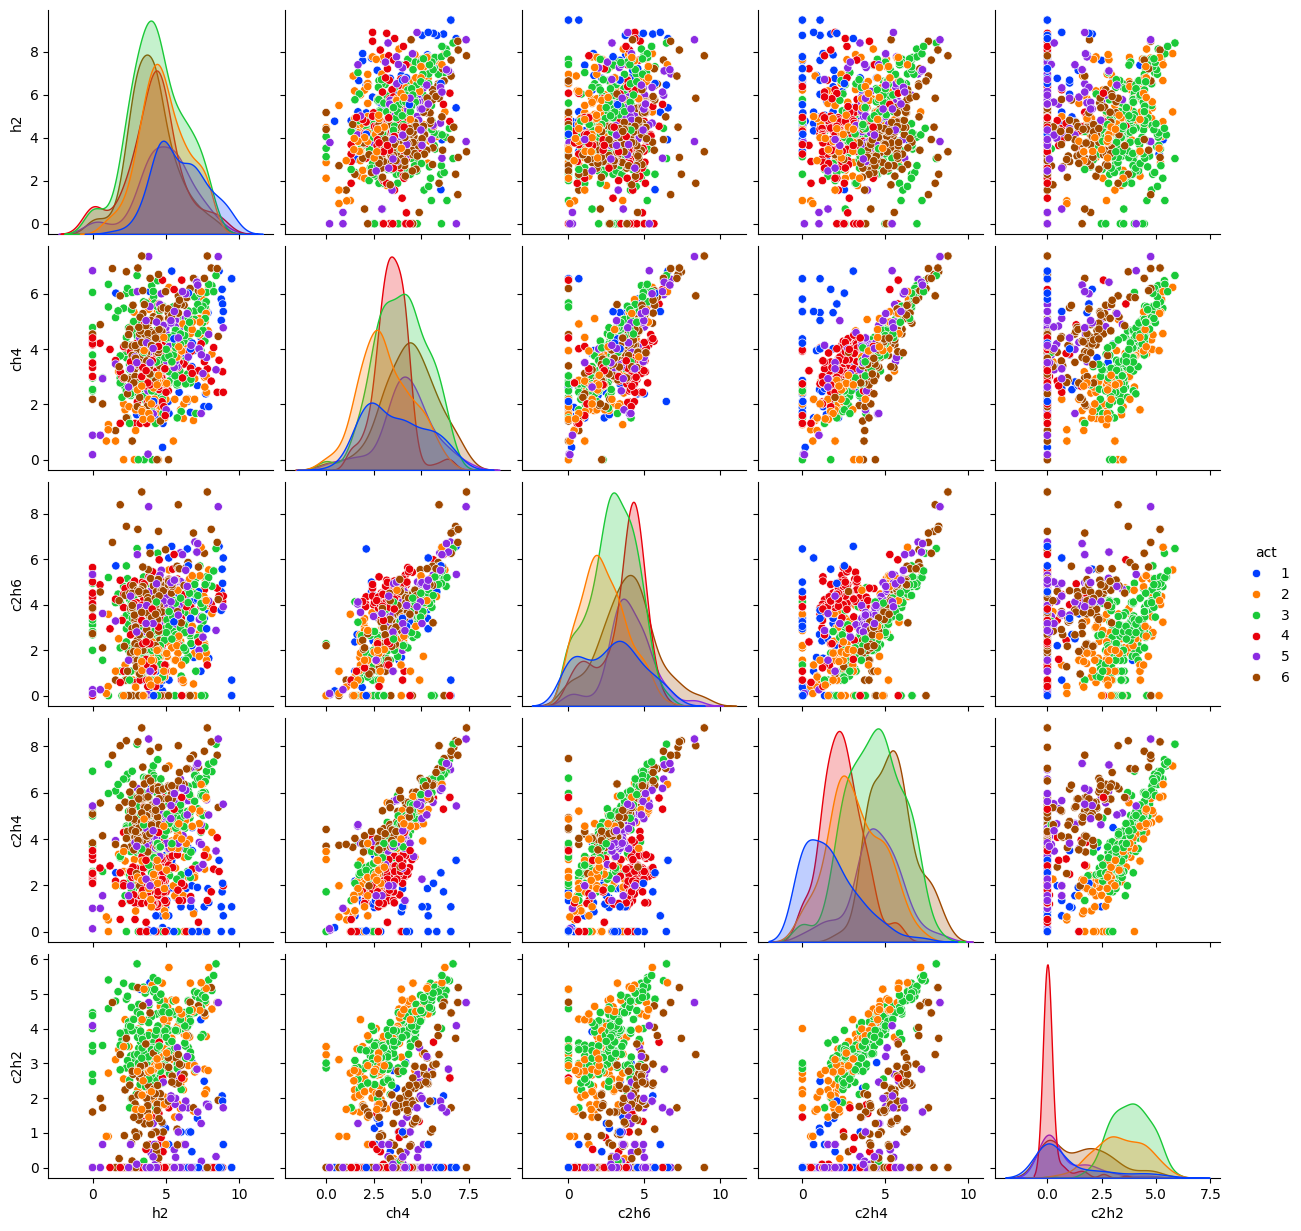

In [84]:
sns.pairplot(df, hue='act', palette='bright')